# CNN_ Cifar10

<h4> With image augmentation </h4>

codes from below source are used in this casesetudy

---



https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

<h3> Customised Dense Net with Image Augmentation </h3>


https://github.com/ludwikbukowski/mysupernet/blob/master/densenetcustom.py

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os
import numpy as np
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras import models, layers
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D
from keras.layers import Concatenate
from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras import backend as k

Using TensorFlow backend.


In [0]:
%time
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [0]:
num_classes = 10

In [0]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 3s 0us/step


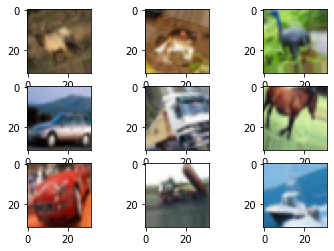

In [0]:
for X_batch, y_batch in datagen.flow(X_train[:9], y_train[:9], batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        
        plt.imshow(X_batch[i].astype('uint8'), cmap=plt.get_cmap('prism'))
    plt.show()
    break

In [0]:
# Dense Block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
            #Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    #if dropout_rate>0:
         #Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    #output = layers.Dense(num_classes, activation='softmax')(flat)
    #replcaing Dense layer by conv layer
    #http://cs231n.github.io/convolutional-networks/#convert
    conv_layer = layers.Conv2D(num_classes, (1,1), use_bias=False ,padding='same')(AvgPooling)
    last = layers.GlobalMaxPooling2D()(conv_layer)   #https://www.researchgate.net/post/Differences_between_Global_Max_Pooling_and_Global_Average_pooling
    output = layers.Activation('softmax')(last)
    return output

In [0]:
num_filter = 24
batch_size = 128
#epochs = 100
compression = 1.041
dropout_rate = 0.2
l = 9

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), activation = 'relu', kernel_initializer = 'he_normal', use_bias=False , padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

In [0]:
def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001
        
lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')

In [0]:
filepath = "{epoch:03d}-{val_accuracy:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = 'val_accuracy', save_best_only=True, verbose = 1)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),#SGD(lr=0.1, momentum=0.9, decay=0.0001, nesterov=True),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=(len(X_train)/batch_size)*5,
    epochs=150,
    verbose = 2,
    validation_data=(X_test, y_test),
    callbacks = [model_chkpt, early_stop]
)


Epoch 1/150
 - 246s - loss: 1.0587 - accuracy: 0.6205 - val_loss: 0.9501 - val_accuracy: 0.6849

Epoch 00001: val_accuracy improved from -inf to 0.68490, saving model to 001-0.685.hdf5
Epoch 2/150
 - 232s - loss: 0.6046 - accuracy: 0.7899 - val_loss: 0.9797 - val_accuracy: 0.7065

Epoch 00002: val_accuracy improved from 0.68490 to 0.70650, saving model to 002-0.706.hdf5
Epoch 3/150
 - 232s - loss: 0.4676 - accuracy: 0.8376 - val_loss: 0.5694 - val_accuracy: 0.8145

Epoch 00003: val_accuracy improved from 0.70650 to 0.81450, saving model to 003-0.814.hdf5
Epoch 4/150
 - 232s - loss: 0.3899 - accuracy: 0.8647 - val_loss: 0.4849 - val_accuracy: 0.8446

Epoch 00004: val_accuracy improved from 0.81450 to 0.84460, saving model to 004-0.845.hdf5
Epoch 5/150
 - 232s - loss: 0.3370 - accuracy: 0.8820 - val_loss: 0.4464 - val_accuracy: 0.8512

Epoch 00005: val_accuracy improved from 0.84460 to 0.85120, saving model to 005-0.851.hdf5
Epoch 6/150
 - 231s - loss: 0.2964 - accuracy: 0.8967 - val_lo

In [0]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 4s 417us/step
Test loss: 0.5058346040025353
Test accuracy: 0.8878999948501587


In [0]:
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')


filepath = "{epoch:03d}-{val_accuracy:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = 'val_accuracy', save_best_only=True, verbose = 1)


#checkpoint = ModelCheckpoint('gdrive/My Drive/cnnoncifar/models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                      # verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  

         
model.load_weights('026-0.909.hdf5')


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# model.fit(xtrain, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1, 
#                     validation_data=(xtest, y_test))
print(model.summary())
model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size), 
    steps_per_epoch=(len(X_train)/batch_size)*5,
              
    epochs=150, verbose = 1,initial_epoch = 30, 
    validation_data=(X_test, y_test),
    callbacks=[model_chkpt,early_stop])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 4s 401us/step
Test loss: 0.39009565761350096
Test accuracy: 0.9103999733924866


In [0]:
model.load_weights('038-0.913.hdf5')
model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

# model.fit(X_train,y_train)

train_acc = model.evaluate(X_train,y_train)
val_acc   = model.evaluate(X_test,y_test)

10000/10000 [==============================] - 4s 402us/step


In [0]:
print(train_acc[1],val_acc[1])

0.9830999970436096 0.913100004196167
